# **MLF Final Project**
### Vladimír Lukáč

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2
import csv
import os
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam, Adamax, SGD, RMSprop
from keras.datasets import cifar10
from keras import regularizers

from PIL import Image

from scipy.signal import decimate

from google.colab import drive

font = {'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# Load the dataset

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

drive.mount('/content/drive')

Mounted at /content/drive


Converting .png to .csv

In [ ]:
#def image_to_csv(image_path, output_file):
#    # Open the image file
#    with Image.open(image_path) as img:
#        # Convert image to grayscale (if it's not already)
#        img = img.convert('L')
#        # Convert image data to a numpy array
#        data = np.array(img)
#        # Open the CSV file for writing
#        with open(output_file, 'w', newline='') as csvfile:
#            writer = csv.writer(csvfile)
#            # Write each row of pixel data to the CSV file
#            for row in data:
#                writer.writerow(row)
#
## Usage example
#image_path = '/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/IMG/img_1.png'
#output_csv_path = 'output.csv'
#image_to_csv(image_path, output_csv_path)

In [3]:
!unzip /content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV.zip

Streaming output truncated to the last 5000 lines.
  inflating: CSV/img_5499.csv        
  inflating: CSV/img_55.csv          
  inflating: CSV/img_550.csv         
  inflating: CSV/img_5500.csv        
  inflating: CSV/img_5501.csv        
  inflating: CSV/img_5502.csv        
  inflating: CSV/img_5503.csv        
  inflating: CSV/img_5504.csv        
  inflating: CSV/img_5505.csv        
  inflating: CSV/img_5506.csv        
  inflating: CSV/img_5507.csv        
  inflating: CSV/img_5508.csv        
  inflating: CSV/img_5509.csv        
  inflating: CSV/img_551.csv         
  inflating: CSV/img_5510.csv        
  inflating: CSV/img_5511.csv        
  inflating: CSV/img_5512.csv        
  inflating: CSV/img_5513.csv        
  inflating: CSV/img_5514.csv        
  inflating: CSV/img_5515.csv        
  inflating: CSV/img_5516.csv        
  inflating: CSV/img_5517.csv        
  inflating: CSV/img_5518.csv        
  inflating: CSV/img_5519.csv        
  inflating: CSV/img_552.csv         

Organizing the 2D data of each *.csv file into 3D matrix, where each "slice" along the x-axis represents one measurement.

In [4]:
#drive.mount('/content/drive')

#trainCSVlist = sorted_alphanumeric(os.listdir('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV/'))
#testCSVlist = sorted_alphanumeric(os.listdir('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/CSV/'))

trainCSVlist = os.listdir('CSV/')
trainCSVlist = sorted(trainCSVlist, key=lambda x: int(x.split('_')[1][:-4]))

#trainDF = np.empty((1,45,51))
#testDF = np.empty((1,45,51))

#for trainFile in trainCSVlist:
#            trainDFtemp = np.genfromtxt('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV/' + trainFile, delimiter=",", dtype=float)
#            trainDFtemp = trainDFtemp.reshape((1, trainDFtemp.shape[0], trainDFtemp.shape[1]))
#            trainDF = np.concatenate([trainDF,trainDFtemp], axis=0)
#
#for testFile in testCSVlist:
#            testDFtemp = np.genfromtxt('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/CSV/' + testFile, delimiter=",", dtype=float)
#            testDFtemp = testDFtemp.reshape((1, testDFtemp.shape[0],testDFtemp.shape[1]))
#            testDF = np.concatenate([testDF,testDFtemp], axis=0)

#example = np.genfromtxt('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/CSV/img_3256.csv', delimiter=',')

#plt.imshow(example)

#print(trainCSVlist.shape)

In [5]:
numpy_arr = []

for single_file_name in trainCSVlist:
  data = pd.read_csv(f'CSV/{single_file_name}').to_numpy()
  numpy_arr.append(data)

numpy_arr = np.asarray(numpy_arr)

In [6]:
numpy_arr.shape

(16182, 44, 51)

The formed Numpy 3D arrays are saved in a compressed format, so that we don't have to start all over each time we run the code (since it takes 54+min to run it on T4)

In [ ]:
# save to google drive in a compressed format

#np.savez_compressed('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/extractedTestcomp.npz',testDF)
#np.savez_compressed('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/extractedTraincomp.npz',trainDF)

Load the compressed data from drive and store in raw form for further processing.

In [7]:
drive.mount('/content/drive')

x_test_raw = np.load('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Test/extractedTestcomp.npz')
#x_train_raw = np.load('/content/drive/MyDrive/ColabNotebooks/MLFfinal/Train/extractedTraincomp.npz')
x_train_raw = numpy_arr
x_test_raw = x_test_raw['arr_0']
#x_train_raw = x_train_raw['arr_0']

y_train_raw = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/MLFfinal/y_train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


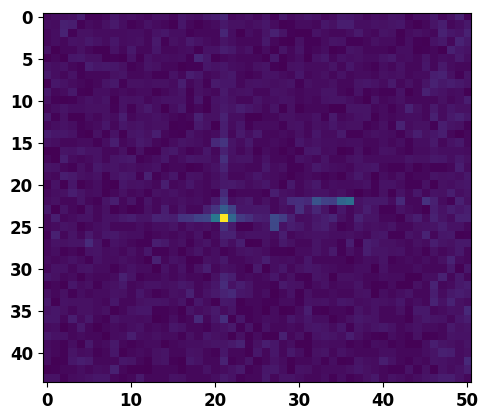

In [8]:
plt.figure()
plt.imshow(x_train_raw[-1])

In [9]:
print(x_test_raw.shape)
print(x_train_raw.shape)
print(y_train_raw.shape)

(4797, 45, 51)
(16182, 44, 51)
(16182, 2)


In [10]:
y_train_raw

,id,target
0,0,0
1,1,1
2,2,0
3,3,2
4,4,2
...,...,...
16177,16177,1
16178,16178,3
16179,16179,2
16180,16180,0


## Data Examination

First, look for NaN values

In [11]:
x_train_raw[0,:,:]
NaNs = np.argwhere(np.isnan(x_train_raw))
print(x_train_raw)
print(NaNs)

x_train_NaN = x_train_raw[1:, :, 1:]
randomNaNs = np.argwhere(np.isnan(x_train_NaN))
print(x_train_NaN)
print(randomNaNs)

[[[31 34 37 ... 30 45 34]
  [32 31 32 ... 38 38 30]
  [32 31 34 ... 39 37 42]
  ...
  [36 34 36 ... 34 38 32]
  [30 32 36 ... 32 41 34]
  [31 36 32 ... 37 39 32]]

 [[34 34 34 ... 34 38 37]
  [30 31 34 ... 34 34 45]
  [30 36 34 ... 34 45 43]
  ...
  [34 34 32 ... 39 41 34]
  [34 34 32 ... 34 45 47]
  [34 34 31 ... 39 43 39]]

 [[36 30 34 ... 34 39 32]
  [32 34 34 ... 41 37 32]
  [32 34 34 ... 38 39 39]
  ...
  [34 37 37 ... 38 34 32]
  [34 36 31 ... 37 41 32]
  [32 32 31 ... 37 34 38]]

 ...

 [[31 31 34 ... 43 38 36]
  [31 31 34 ... 39 36 34]
  [31 31 32 ... 43 45 47]
  ...
  [39 37 39 ... 38 41 40]
  [34 34 34 ... 40 37 42]
  [43 34 40 ... 34 38 37]]

 [[30 36 34 ... 34 43 31]
  [32 30 31 ... 36 39 30]
  [31 34 34 ... 45 37 39]
  ...
  [36 38 32 ... 40 37 31]
  [36 31 32 ... 34 38 32]
  [32 32 38 ... 39 34 37]]

 [[34 37 37 ... 38 46 32]
  [37 36 46 ... 34 37 42]
  [34 37 48 ... 41 39 47]
  ...
  [37 31 32 ... 37 36 51]
  [31 32 34 ... 36 39 45]
  [39 39 32 ... 45 39 34]]]
[]
[[[34 3

Secondly, identify the labels and their distribution

In [12]:
y_train_raw['target'].value_counts() #class imbalance

target
1    5417
3    4400
2    4307
0    2058
Name: count, dtype: int64

# Data Preprocessing

In [13]:
# removing empty slice and index column, as well as first row, since it contains NaN values, from x_train and test data

#x_train = x_train_raw[1:, 1:, 1:]
x_test = x_test_raw[1:, 1:, 0:]
x_train = x_train_raw
print(x_test.shape)
print(x_train.shape)


(4796, 44, 51)
(16182, 44, 51)


We remove the obsolete id column from the label data, and we shift the values to range from 0 to 2 rather than 1 to 3.

In [14]:
# remove id column from y_train, shift values by 1

y_train = y_train_raw.drop(columns='id')

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_train_raw.shape)

(16182, 44, 51)
(16182, 1)
(16182, 44, 51)


Checking if all NaN values were removed.

In [16]:
print(np.argwhere(np.isnan(x_train)),np.argwhere(np.isnan(x_test))) #no NaNs left

[] []


Data examination

In [17]:
print(f'Maximum:{x_train.max()}, Minimum: {x_train.min()}, Mean: {x_train.mean()}, Median: {np.median(x_train)}')
print(np.where(x_train == x_train.max()))

Maximum:215, Minimum: 30, Mean: 37.24724331143228, Median: 34.0
(array([    0,     1,     2, ..., 16179, 16180, 16181]), array([22, 21, 22, ..., 18, 22, 24]), array([20, 18, 20, ..., 18, 20, 21]))


## **Trim and scale**

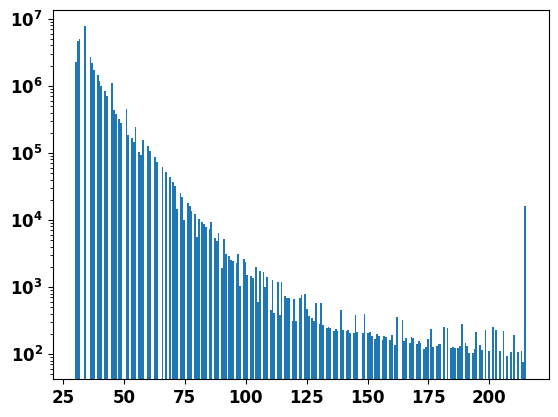

Percentage of values below 125: 99.90952679315566 %


In [18]:
x_train_undim = np.reshape(x_train, (1,36312408))

plt.figure()
plt.yscale('log')
plt.hist(x_train_undim.flatten(), bins=250)

plt.show()

print(f'Percentage of values below 125: {len(np.where(x_train <= 125)[0])/x_train.size*100} %')

Apply scaler, since there are outliers. A Robust scaler has been applied.

In [19]:
#final preprocesing, scaling
scaler = RobustScaler()

#x_trainscaled = x_train.astype('float32') / 255.0

x_trainScaled = np.empty([x_train.shape[0],44*51,1])
for slice in range(x_train.shape[0]):
  x_trainScaled[slice,:,:] = np.reshape(x_train[slice,:,:],[1,44*51,1])
  x_trainScaled[slice,:,:] = scaler.fit_transform(x_trainScaled[slice,:,:])

#x_testscaled = x_test.astype('float32') / 255.0

x_testScaled = np.empty([x_test.shape[0],44*51,1])
for slice in range(x_test.shape[0]):
  x_testScaled[slice,:,:] = np.reshape(x_test[slice,:,:],[1,44*51,1])
  x_testScaled[slice,:,:] = scaler.fit_transform(x_testScaled[slice,:,:])


In [20]:
scaler.center_

array([71.])

In [21]:
print(x_testScaled.shape)
print(x_trainScaled.shape)
#print(y_trainEncoded.shape)

(4796, 2244, 1)
(16182, 2244, 1)


Visulaising scaled data and scaled data statistics

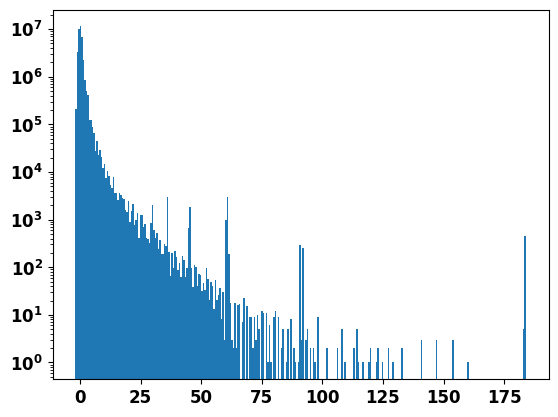

In [22]:
plt.figure()
plt.yscale('log')
plt.hist(x_trainScaled.flatten(), bins=300)

plt.show()

In [23]:
print(f'Maximum:{x_trainScaled.max()}, Minimum: {x_trainScaled.min()}, Mean: {x_trainScaled.mean()}, Median: {np.median(x_trainScaled)}')

Maximum:184.0, Minimum: -2.04, Mean: 0.2720676023477983, Median: 0.0


In [24]:
len(np.where(x_trainScaled <= 120)[0])/x_trainScaled.size*100

99.99866712226851

### **Reduce extra dimensions**

In [25]:
x_trainScaled = np.squeeze(x_trainScaled)
x_testScaled = np.squeeze(x_testScaled)

y_train = y_train.to_numpy()
y_train = np.squeeze(y_train)

**undersample largest class, one-hot encoding of labels**

In [26]:
class0ind = np.where(y_train==1)[0]
class0indDec = np.random.choice(class0ind, 1600, replace=False)

x_trainScaled = np.delete(x_trainScaled, class0indDec, axis=0)
y_trainDec = np.delete(y_train, class0indDec, axis=0)

y_trainEncoded = to_categorical(y_trainDec, num_classes = 4)

### **Check data**

In [27]:
np.unique(y_trainDec, return_counts = True)

(array([0, 1, 2, 3]), array([2058, 3817, 4307, 4400]))

In [28]:
print("y_testEncoded shape:", x_testScaled.shape)
print("x_trainScaled shape:", x_trainScaled.shape)
print("y_trainEncoded shape:", y_trainEncoded.shape)

y_testEncoded shape: (4796, 2244)
x_trainScaled shape: (14582, 2244)
y_trainEncoded shape: (14582, 4)


# Building the model

In [29]:
model = Sequential()
#model = Sequential()
#model.add(Flatten(input_shape=(2244,)))
#model.add(Dense(2244, activation='gelu'))
#model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
#model.add(Dense(16, activation='gelu'))
#model.add(Dense(3, activation='softmax'))


#model.add(Flatten(input_shape=(2244,)))
#model.add(Dense(3072, activation='gelu'))
#model.add(Dense(2244, activation='gelu'))
#model.add(Dense(128, activation='gelu'))
#model.add(Dense(3, activation='softmax'))

model.add(Flatten(input_shape=(2244,)))
model.add(Dense(16000, activation='gelu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='gelu'))
model.add(Dense(64, activation='gelu'))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2244)              0         
                                                                 
 dense (Dense)               (None, 16000)             35920000  
                                                                 
 dropout (Dropout)           (None, 16000)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               2048128   
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 37976644 (144.87 MB)
Trainable params: 379

Callback used for saving build model

In [30]:
from tensorflow.python import keras
from tensorflow import keras

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "/content/drive/MyDrive/ColabNotebooks/MLFfinal/model_v1.tf", save_best_only=True, monitor="val_loss"), # model saving in the drive, beware of file overwrite
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, min_lr=0.000007), # decreasing LR, 0.000007 - minimum
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)] # Early stopping


Loading the saved model

In [ ]:
#model_cnn = keras.models.load_model("/content/drive/cnn_v2.tf")

In [31]:
#optimizer = SGD(learning_rate = 0.01)
#model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimizer = Adamax(learning_rate = 0.005, epsilon = 0.2, beta_1=0.9, beta_2=0.999)
#optimizer = SGD(learning_rate = 0.001)
#optimizer = RMSprop(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [32]:
history = model.fit(x_trainScaled, y_trainEncoded, epochs=20, batch_size=32, verbose=1, validation_split = 0.2)

Epoch 1/20
365/365 [==============================] - 10s 15ms/step - loss: 0.5063 - accuracy: 0.8116 - val_loss: 0.3403 - val_accuracy: 0.8831
Epoch 2/20
365/365 [==============================] - 6s 16ms/step - loss: 0.2355 - accuracy: 0.9192 - val_loss: 0.2691 - val_accuracy: 0.9023
Epoch 3/20
365/365 [==============================] - 5s 15ms/step - loss: 0.1329 - accuracy: 0.9558 - val_loss: 0.2118 - val_accuracy: 0.9277
Epoch 4/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0915 - accuracy: 0.9705 - val_loss: 0.2775 - val_accuracy: 0.9164
Epoch 5/20
365/365 [==============================] - 6s 16ms/step - loss: 0.0603 - accuracy: 0.9818 - val_loss: 0.1806 - val_accuracy: 0.9366
Epoch 6/20
365/365 [==============================] - 5s 15ms/step - loss: 0.0302 - accuracy: 0.9912 - val_loss: 0.2227 - val_accuracy: 0.9308
Epoch 7/20
365/365 [==============================] - 5s 14ms/step - loss: 0.0396 - accuracy: 0.9885 - val_loss: 0.1960 - val_accuracy: 0.930

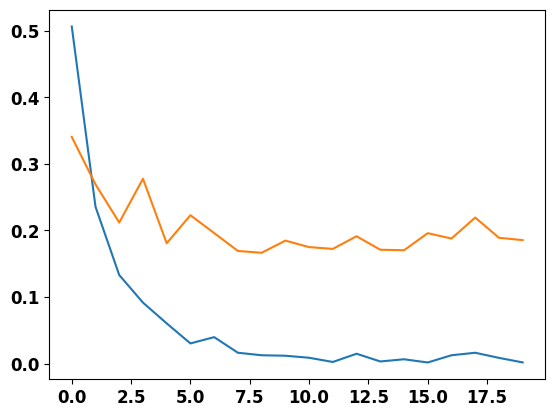

In [33]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

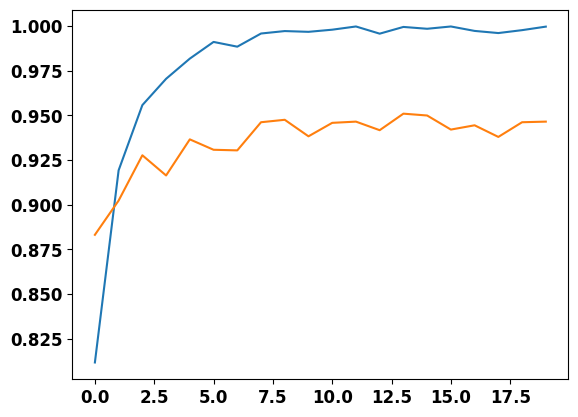

In [34]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [35]:
score = model.evaluate(x_trainScaled, y_trainEncoded, verbose=0)
print('Training loss:', score[0])
print(f'Training accuracy: {score[1]*100} %')

Training loss: 0.03770499676465988
Training accuracy: 98.9301860332489 %


# **Outputing data**

In [36]:
print(x_testScaled.shape)

(4796, 2244)


In [37]:
predictions = model.predict(x_testScaled)
predictions = pd.DataFrame(predictions)
predictions = predictions.idxmax(axis=1)+1
predictions = pd.DataFrame(predictions, columns=['target'])
predictions.insert(0,'id',np.arange(len(predictions)))

150/150 [==============================] - 0s 2ms/step


In [38]:
predictions.to_csv('predictions_v1.csv', index=False)